# mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd gdrive/My Drive/app/asd_classification

/content/gdrive/My Drive/app/asd_classification


# read and process phenotypic data

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
df=pd.read_csv('MRI/Phenotypic_V1_0b_preprocessed1.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,...,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,anat_cnr,anat_efc,anat_fber,anat_fwhm,anat_qi1,anat_snr,func_efc,func_fber,func_fwhm,func_dvars,func_outlier,func_quality,func_mean_fd,func_num_fd,func_perc_fd,func_gsr,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,1,Ambi,NaN,103.0,116.0,89.0,WASI,WASI,WASI,16.0,9.0,5.0,4.0,1.0,4.0,12.0,4.0,8.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,10.201539,1.194664,16.223458,3.878000,0.152711,12.072452,0.613128,45.446551,1.873339,1.054931,0.000641,0.011443,0.116828,8.0,3.980100,0.054346,fail,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,R,NaN,124.0,128.0,115.0,WASI,WASI,WASI,27.0,22.0,5.0,3.0,1.0,4.0,13.0,5.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7.165701,1.126752,10.460008,4.282238,0.161716,9.241155,0.578301,56.286350,2.012112,0.949857,0.000474,0.031781,0.322092,135.0,67.164179,0.041862,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,R,NaN,113.0,108.0,117.0,WASI,WASI,WASI,19.0,12.0,5.0,3.0,1.0,4.0,18.0,6.0,12.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7.698144,1.226218,9.725750,3.881684,0.174186,9.323463,0.578960,63.317943,1.866104,1.180605,0.008262,0.014260,0.127745,29.0,14.427861,0.046745,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,R,NaN,119.0,117.0,118.0,WASI,WASI,WASI,23.0,19.0,3.0,4.0,1.0,4.0,12.0,4.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,9.071807,1.256278,11.198226,3.628667,0.119269,10.814200,0.556064,70.800354,1.918278,1.092030,0.001711,0.019205,0.128136,22.0,10.945274,0.027963,OK,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,L,NaN,109.0,99.0,119.0,WASI,WASI,WASI,13.0,10.0,4.0,3.0,1.0,4.0,12.0,4.0,8.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,8.026798,1.407166,6.282055,3.674539,0.130647,10.123574,0.562942,75.364679,2.213873,1.086830,0.001500,0.006919,0.070143,3.0,1.492537,0.054006,OK,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1


In [4]:
y=df['DX_GROUP']
fID = df["FILE_ID"]
df.drop(["SUB_ID","X","Unnamed: 0","Unnamed: 0.1","FIQ_TEST_TYPE","VIQ_TEST_TYPE","PIQ_TEST_TYPE"],1,inplace=True)
df.head()

,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,COMORBIDITY,CURRENT_MED_STATUS,MEDICATION_NAME,OFF_STIMULANTS_AT_SCAN,...,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,anat_cnr,anat_efc,anat_fber,anat_fwhm,anat_qi1,anat_snr,func_efc,func_fber,func_fwhm,func_dvars,func_outlier,func_quality,func_mean_fd,func_num_fd,func_perc_fd,func_gsr,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,50002,PITT,no_filename,1,1,16.77,1,Ambi,NaN,103.0,116.0,89.0,16.0,9.0,5.0,4.0,1.0,4.0,12.0,4.0,8.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,10.201539,1.194664,16.223458,3.878000,0.152711,12.072452,0.613128,45.446551,1.873339,1.054931,0.000641,0.011443,0.116828,8.0,3.980100,0.054346,fail,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,50003,PITT,Pitt_0050003,1,1,24.45,1,R,NaN,124.0,128.0,115.0,27.0,22.0,5.0,3.0,1.0,4.0,13.0,5.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Fluoxetine,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7.165701,1.126752,10.460008,4.282238,0.161716,9.241155,0.578301,56.286350,2.012112,0.949857,0.000474,0.031781,0.322092,135.0,67.164179,0.041862,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,50004,PITT,Pitt_0050004,1,1,19.09,1,R,NaN,113.0,108.0,117.0,19.0,12.0,5.0,3.0,1.0,4.0,18.0,6.0,12.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7.698144,1.226218,9.725750,3.881684,0.174186,9.323463,0.578960,63.317943,1.866104,1.180605,0.008262,0.014260,0.127745,29.0,14.427861,0.046745,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,50005,PITT,Pitt_0050005,1,1,13.73,2,R,NaN,119.0,117.0,118.0,23.0,19.0,3.0,4.0,1.0,4.0,12.0,4.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Fluoxetine,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,9.071807,1.256278,11.198226,3.628667,0.119269,10.814200,0.556064,70.800354,1.918278,1.092030,0.001711,0.019205,0.128136,22.0,10.945274,0.027963,OK,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,50006,PITT,Pitt_0050006,1,1,13.37,1,L,NaN,109.0,99.0,119.0,13.0,10.0,4.0,3.0,1.0,4.0,12.0,4.0,8.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,8.026798,1.407166,6.282055,3.674539,0.130647,10.123574,0.562942,75.364679,2.213873,1.086830,0.001500,0.006919,0.070143,3.0,1.492537,0.054006,OK,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1


In [0]:
df.drop(["subject","SITE_ID","HANDEDNESS_SCORES"],1,inplace=True)
df['HANDEDNESS_CATEGORY'].isnull().values
temp=list(zip(list(df.index),df['HANDEDNESS_CATEGORY'].isnull().values))
temp=map(lambda x: x[0] if x[1] else np.nan ,temp)
temp=list(temp)
temp=np.array(temp)
np.isnan(temp)
temp1=[]

for i in temp:
    if not np.isnan(i):
        temp1.append(i)
        
df.drop(temp1,axis=0,inplace=True)
df.dropna(axis=1,thresh=400,inplace=True)

In [6]:
len(df.columns)

33

In [7]:
df['CURRENT_MED_STATUS'].fillna(0,inplace = True)
df['HANDEDNESS_CATEGORY']=df['HANDEDNESS_CATEGORY'].map({'R':'R','L':'L','Ambi':'Ambi','mixed':'Ambi','L->R':'Ambi',-9999:'Ambi'})
df_processed=pd.get_dummies(df)
df_processed

,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,EYE_STATUS_AT_SCAN,anat_cnr,anat_efc,anat_fber,anat_fwhm,anat_qi1,anat_snr,func_efc,func_fber,func_fwhm,func_dvars,func_outlier,func_quality,func_mean_fd,func_num_fd,func_perc_fd,func_gsr,SUB_IN_SMP,FILE_ID_CMU_a_0050642,FILE_ID_CMU_a_0050646,FILE_ID_CMU_a_0050647,FILE_ID_CMU_a_0050649,FILE_ID_CMU_a_0050653,FILE_ID_CMU_a_0050654,FILE_ID_CMU_a_0050656,FILE_ID_CMU_a_0050659,FILE_ID_CMU_a_0050660,FILE_ID_CMU_a_0050663,FILE_ID_CMU_a_0050664,FILE_ID_CMU_a_0050665,FILE_ID_CMU_a_0050666,FILE_ID_CMU_a_0050668,FILE_ID_CMU_b_0050643,...,FILE_ID_Yale_0050611,FILE_ID_Yale_0050612,FILE_ID_Yale_0050613,FILE_ID_Yale_0050614,FILE_ID_Yale_0050615,FILE_ID_Yale_0050616,FILE_ID_Yale_0050617,FILE_ID_Yale_0050618,FILE_ID_Yale_0050619,FILE_ID_Yale_0050620,FILE_ID_Yale_0050621,FILE_ID_Yale_0050622,FILE_ID_Yale_0050623,FILE_ID_Yale_0050624,FILE_ID_Yale_0050625,FILE_ID_Yale_0050626,FILE_ID_Yale_0050627,FILE_ID_Yale_0050628,FILE_ID_no_filename,HANDEDNESS_CATEGORY_Ambi,HANDEDNESS_CATEGORY_L,HANDEDNESS_CATEGORY_R,CURRENT_MED_STATUS_0,CURRENT_MED_STATUS_-9999,CURRENT_MED_STATUS_0,CURRENT_MED_STATUS_1,CURRENT_MED_STATUS_`,qc_rater_1_OK,qc_rater_1_fail,qc_rater_1_maybe,qc_anat_rater_2_OK,qc_anat_rater_2_fail,qc_anat_rater_2_maybe,qc_func_rater_2_OK,qc_func_rater_2_fail,qc_func_rater_2_maybe,qc_anat_rater_3_OK,qc_anat_rater_3_fail,qc_func_rater_3_OK,qc_func_rater_3_fail
0,1,1,16.77,1,103.0,116.0,89.0,2,10.201539,1.194664,16.223458,3.878000,0.152711,12.072452,0.613128,45.446551,1.873339,1.054931,0.000641,0.011443,0.116828,8.0,3.980100,0.054346,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1
1,1,1,24.45,1,124.0,128.0,115.0,2,7.165701,1.126752,10.460008,4.282238,0.161716,9.241155,0.578301,56.286350,2.012112,0.949857,0.000474,0.031781,0.322092,135.0,67.164179,0.041862,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0
2,1,1,19.09,1,113.0,108.0,117.0,2,7.698144,1.226218,9.725750,3.881684,0.174186,9.323463,0.578960,63.317943,1.866104,1.180605,0.008262,0.014260,0.127745,29.0,14.427861,0.046745,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0
3,1,1,13.73,2,119.0,117.0,118.0,2,9.071807,1.256278,11.198226,3.628667,0.119269,10.814200,0.556064,70.800354,1.918278,1.092030,0.001711,0.019205,0.128136,22.0,10.945274,0.027963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0
4,1,1,13.37,1,109.0,99.0,119.0,2,8.026798,1.407166,6.282055,3.674539,0.130647,10.123574,0.562942,75.364679,2.213873,1.086830,0.001500,0.006919,0.070143,3.0,1.492537,0.054006,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0
5,1,1,17.78,1,110.0,106.0,112.0,2,5.775897,1.161231,6.991093,4.104707,0.236214,7.638746,0.607554,64.682109,1.834521,1.099380,0.002805,0.028284,0.151246,38.0,18.905473,0.055615,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0
6,1,1,32.45,1,123.0,123.0,114.0,2,6.669686,1.241491,7.945937,3.831462,0.131733,8.507972,0.571447,60.682083,1.909622,1.038369,0.000524,0.018028,0.169275,58.0,28.855721,0.056363,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0
7,1,1,33.86,1,126.0,118.0,128.0,2,4.447948,1.201311,7.858095,3.622118,0.197792,6.552231,0.596593,64.427431,2.032504,1.180188,0.003165,0.010513,0.091976,14.0,6.965174,0.053051,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0
8,1,1,35.20,1,81.0,81.0,93.0,2,11.450388,0.931668,29.233811,3.852356,0.073776,13.292140,0.491360,84.924849,2.021997,1.116337,0.001126,0.006494,0.072545,7.0,3.482587,0.036569,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0

# prepare input and label

In [0]:
df_processed=df_processed.replace(-9999,np.nan)
df_processed['DSM_IV_TR']=list(map(lambda x: str(x),df_processed['DSM_IV_TR'].values))
df_processed=pd.get_dummies(df_processed)
mean_val=dict(df_processed.mean())
for i in df_processed.columns:
    df_processed[i]=df_processed[i].fillna(mean_val[i])
    
temp2=[]
for i in y.index.values:
    if i not in temp1:
        temp2.append(i)
        
y=y[temp2].values
y=y-1


# label to one-hot

In [9]:
import keras
y=keras.utils.np_utils.to_categorical(y)

Using TensorFlow backend.


# Design standard neural network using adam optimizer

In [10]:
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Model
from keras.utils import plot_model
inputs = Input(shape=[len(df_processed.columns),])
x = Dense(20, activation = "relu")(inputs)
x = BatchNormalization()(x)
x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation = "softmax")(x)

model = Model(inputs = inputs, outputs = x)

model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
               metrics = ["accuracy"])
model.summary()
plot_model(model, to_file='model.png')

W0824 07:09:22.706313 140491611629440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 07:09:22.719506 140491611629440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 07:09:22.722465 140491611629440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 07:09:22.806523 140491611629440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0824 07:09:22.927181 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 811)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                16240     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10)                40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total para

# Training for 100 epochs

In [0]:
df_temp=scale(df_processed)
history_tl = model.fit(df_processed,y,batch_size=128,epochs=100,validation_split = 0.3)

Train on 557 samples, validate on 240 samples
Epoch 1/100
557/557 [==============================] - 1s 2ms/step - loss: 1.2476 - acc: 0.4722 - val_loss: 1.3374 - val_acc: 0.5458
Epoch 2/100
557/557 [==============================] - 0s 102us/step - loss: 1.1325 - acc: 0.5171 - val_loss: 1.3155 - val_acc: 0.5208
Epoch 3/100
557/557 [==============================] - 0s 99us/step - loss: 1.1611 - acc: 0.4865 - val_loss: 1.3387 - val_acc: 0.5208
Epoch 4/100
557/557 [==============================] - 0s 98us/step - loss: 1.0867 - acc: 0.5027 - val_loss: 1.2278 - val_acc: 0.5250
Epoch 5/100
557/557 [==============================] - 0s 113us/step - loss: 1.0765 - acc: 0.5314 - val_loss: 1.1857 - val_acc: 0.5583
Epoch 6/100
557/557 [==============================] - 0s 107us/step - loss: 0.9526 - acc: 0.5548 - val_loss: 1.2098 - val_acc: 0.5292
Epoch 7/100
557/557 [==============================] - 0s 103us/step - loss: 0.9986 - acc: 0.5189 - val_loss: 1.2291 - val_acc: 0.5083
Epoch 8/100
5

model.fit(df_processed,y,batch_size=64,epoch=10)

# plot the loss and accuracy curve

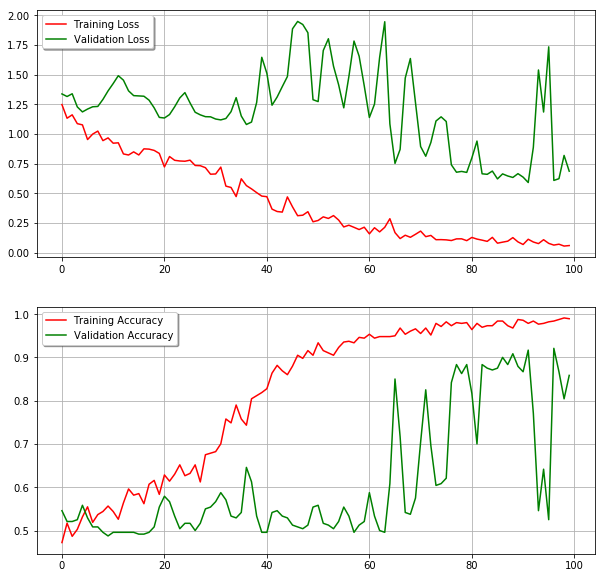

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history_tl.history['loss'], color='r', label='Training Loss')
ax[0].plot(history_tl.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)

ax[1].plot(history_tl.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history_tl.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)
plt.savefig("result+"+str(100)+".png")
plt.show()

In [0]:
import os
import re

In [0]:
a = os.listdir("reho")

In [0]:
re.findall('(.*)_reho.nii.gz',a[0])

['UCLA_2_0051308']

In [0]:
a[0].split()

['UCLA_2_0051308_reho.nii.gz']

In [0]:
df=df[["FILE_ID","DX_GROUP"]]

In [0]:
temp1=pd.Index(df.FILE_ID)

In [0]:
os.getcwd()

'/Users/smcmsmc/Desktop/untitled folder'

In [0]:
temp1=pd.Index(df.FILE_ID)
file_class=[]
for i in a:
    temp=re.findall('(.*)_reho.nii.gz',i)[0]
    if temp in df.FILE_ID.values:
        loc=temp1.get_loc(temp)
        file_class.append((os.path.join(os.getcwd(),'reho',i),df.DX_GROUP.values[loc]))
        

IndexError: list index out of range

In [0]:
import matplotlib
matplotlib.use("Tkagg")

from matplotlib import pylab as plt
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import os


In [0]:
os.getcwd()

'/Users/smcmsmc/Desktop/untitled folder'

In [0]:
file_class

[('/Users/smcmsmc/Desktop/untitled folder/reho/UCLA_2_0051308_reho.nii.gz', 2),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/UM_2_0050421_reho.nii.gz', 2),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/Leuven_1_0050705_reho.nii.gz',
  1),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/NYU_0051016_reho.nii.gz', 1),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/UCLA_1_0051282_reho.nii.gz', 2),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/NYU_0051104_reho.nii.gz', 2),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/NYU_0050979_reho.nii.gz', 1),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/Caltech_0051490_reho.nii.gz',
  2),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/NYU_0051066_reho.nii.gz', 2),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/NYU_0050984_reho.nii.gz', 1),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/Yale_0050619_reho.nii.gz', 1),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/NYU_0051038_reho.nii.gz', 2),
 ('/Users/smcmsmc/Desktop/untitled folder/reho/KKI_0050

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()

In [0]:
b = list()

In [0]:
for path,classes in file_class:
    img = nib.load(path)
    temp=img.get_data()
    b.append((temp,classes))

In [0]:
from keras.layers import Dense, Input, Convolution2D, Activation, Flatten, MaxPooling2D,GlobalAveragePooling2D

In [0]:
from keras.layers import Dense, Input, Convolution2D, Activation, Flatten, MaxPooling2D,GlobalAveragePooling2D
from keras.models import Model
from keras.utils.np_utils import *

X=[i[0] for i in b]
X=np.array(X).reshape(884,61,73,61)
Y=[i[1] for i in b]
Y = np.array(Y)-1
Y = to_categorical(Y)

inputs = Input(shape = (61,73,61))
con1 = Convolution2D(64,[3,3], padding = "same")(inputs)
pool1 = MaxPooling2D(2,2)(con1)
ac1 = Activation('relu')(pool1)

con2 = Convolution2D(128,[3,3], padding = "same")(inputs)
pool2 = MaxPooling2D(2,2)(con2)
ac2 = Activation('relu')(pool2)

flatten = Flatten()(ac2)

fc1 = Dense(100)(flatten)
dp1 = dropout(0.5)(fc1)
ac3 = Activation('relu')(dp1)
fc2 = Dense(2)(ac3)
ac4 = Activation('softmax')(fc2)

model = Model(inputs = inputs, outputs = ac4)

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
               metrics = ["accuracy"])
model.fit(X,Y,batch_size = 32, epochs = 100,validation_split=0.3,shuffle = True)

Train on 618 samples, validate on 266 samples
Epoch 1/100
618/618 [==============================] - 23s 38ms/step - loss: 0.7751 - acc: 0.4919 - val_loss: 0.6899 - val_acc: 0.5414
Epoch 2/100
618/618 [==============================] - 18s 30ms/step - loss: 0.6886 - acc: 0.5421 - val_loss: 0.6874 - val_acc: 0.5414
Epoch 3/100
618/618 [==============================] - 18s 30ms/step - loss: 0.6794 - acc: 0.5534 - val_loss: 0.6873 - val_acc: 0.5338
Epoch 4/100
618/618 [==============================] - 18s 29ms/step - loss: 0.6524 - acc: 0.6278 - val_loss: 0.6865 - val_acc: 0.5376
Epoch 5/100
618/618 [==============================] - 18s 29ms/step - loss: 0.6184 - acc: 0.6699 - val_loss: 0.6854 - val_acc: 0.5489
Epoch 6/100
618/618 [==============================] - 18s 29ms/step - loss: 0.5444 - acc: 0.7460 - val_loss: 0.8485 - val_acc: 0.4925
Epoch 7/100
618/618 [==============================] - 18s 30ms/step - loss: 0.4952 - acc: 0.7330 - val_loss: 0.7065 - val_acc: 0.5827
Epoch 8/1

KeyboardInterrupt: 

In [0]:
model.input

<tf.Tensor 'input_23:0' shape=(?, 61, 73, 61) dtype=float32>

In [0]:
type(con1)

tensorflow.python.framework.ops.Tensor

In [0]:
from keras.applications.resnet50 import ResNet50

In [0]:
inputs = Input(shape = (61,73,61))

In [0]:
prediction=GlobalAveragePooling2D()(out)
prediction=Dense(2,activation='softmax')(prediction)
models=Model(inputs=inputs,outputs=prediction)

In [0]:
models.compile(optimizer = "adam",
              loss = "binary_crossentropy",
               metrics = ["accuracy"])
models.fit(X,Y,batch_size = 32, epochs = 100,validation_split=0.3,shuffle = True)

Train on 618 samples, validate on 266 samples
Epoch 1/100
618/618 [==============================] - 105s 171ms/step - loss: 1.2998 - acc: 0.4951 - val_loss: 8.5114 - val_acc: 0.4586
Epoch 2/100
618/618 [==============================] - 32s 51ms/step - loss: 0.8238 - acc: 0.5243 - val_loss: 0.8776 - val_acc: 0.4850
Epoch 3/100
618/618 [==============================] - 31s 50ms/step - loss: 0.7011 - acc: 0.5696 - val_loss: 1.2770 - val_acc: 0.4586
Epoch 4/100
618/618 [==============================] - 31s 50ms/step - loss: 0.7024 - acc: 0.6278 - val_loss: 4.6074 - val_acc: 0.5338
Epoch 5/100
618/618 [==============================] - 31s 49ms/step - loss: 0.7115 - acc: 0.6472 - val_loss: 5.9311 - val_acc: 0.5226
Epoch 6/100
618/618 [==============================] - 31s 49ms/step - loss: 0.6437 - acc: 0.6602 - val_loss: 0.9647 - val_acc: 0.5075
Epoch 7/100
618/618 [==============================] - 32s 52ms/step - loss: 0.5223 - acc: 0.7605 - val_loss: 0.9228 - val_acc: 0.5489
Epoch 8

KeyboardInterrupt: 

In [0]:
temp=re.findall('(.*)_reho.nii.gz',i)[0]

In [0]:
from keras.layers import Dense, Input, Convolution2D, Activation, Flatten, MaxPooling2D,GlobalAveragePooling2D
from keras.models import Model
from keras.utils.np_utils import *

X=[i[0] for i in b]
X=np.array(X).reshape(884,61,73,61)
Y=[i[1] for i in b]
Y = np.array(Y)-1
Y = to_categorical(Y)

inputs = Input(shape = (61,73,61))
con1 = Convolution2D(64,[3,3], padding = "same")(inputs)
pool1 = MaxPooling2D(2,2)(con1)
ac1 = Activation('relu')(pool1)

con2 = Convolution2D(128,[3,3], padding = "same")(inputs)
pool2 = MaxPooling2D(2,2)(con2)
ac2 = Activation('relu')(pool2)

flatten = Flatten()(ac2)

fc1 = Dense(100)(flatten)
dp1 = dropout(0.5)(fc1)
ac3 = Activation('relu')(dp1)
fc2 = Dense(2)(ac3)
ac4 = Activation('softmax')(fc2)

model = Model(inputs = inputs, outputs = ac4)

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
               metrics = ["accuracy"])
model.fit(X,Y,batch_size = 32, epochs = 100,validation_split=0.3,shuffle = True)


Using TensorFlow backend.


NameError: name 'b' is not defined

In [0]:
df.head()

,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,FIQ,VIQ,PIQ,CURRENT_MED_STATUS,...,func_mean_fd,func_num_fd,func_perc_fd,func_gsr,qc_rater_1,qc_anat_rater_2,qc_func_rater_2,qc_anat_rater_3,qc_func_rater_3,SUB_IN_SMP
0,no_filename,1,1,16.77,1,Ambi,103.0,116.0,89.0,0,...,0.116828,8.0,3.980100,0.054346,fail,OK,fail,OK,fail,1
1,Pitt_0050003,1,1,24.45,1,R,124.0,128.0,115.0,1,...,0.322092,135.0,67.164179,0.041862,OK,OK,OK,OK,OK,1
2,Pitt_0050004,1,1,19.09,1,R,113.0,108.0,117.0,0,...,0.127745,29.0,14.427861,0.046745,OK,OK,OK,OK,OK,1
3,Pitt_0050005,1,1,13.73,2,R,119.0,117.0,118.0,1,...,0.128136,22.0,10.945274,0.027963,OK,OK,maybe,OK,OK,0
4,Pitt_0050006,1,1,13.37,1,L,109.0,99.0,119.0,0,...,0.070143,3.0,1.492537,0.054006,OK,OK,maybe,OK,OK,1


In [0]:
age_13 = df[["FILE_ID","AGE_AT_SCAN","DX_GROUP"]]

In [0]:
print(age_13)

               FILE_ID  AGE_AT_SCAN  DX_GROUP
0          no_filename        16.77         1
1         Pitt_0050003        24.45         1
2         Pitt_0050004        19.09         1
3         Pitt_0050005        13.73         1
4         Pitt_0050006        13.37         1
5         Pitt_0050007        17.78         1
6         Pitt_0050008        32.45         1
7         Pitt_0050009        33.86         1
8         Pitt_0050010        35.20         1
9         Pitt_0050011        16.93         1
10        Pitt_0050012        21.48         1
11        Pitt_0050013         9.33         1
12        Pitt_0050014        14.20         1
13        Pitt_0050015        14.20         1
14        Pitt_0050016        21.82         1
15        Pitt_0050017        22.70         1
16        Pitt_0050019        27.81         1
17        Pitt_0050020        20.83         1
18        Pitt_0050022        16.99         1
19        Pitt_0050023        12.64         1
20        Pitt_0050024        22.6

In [0]:
print(age_13["AGE_AT_SCAN"][1])

24.45


In [0]:
for i in 